In [28]:
import os
import torch
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L

import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

TRAIN

In [29]:
# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, hidden_dim: int = 64, learning_rate=10e-3):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 3))
        self.decoder = nn.Sequential(nn.Linear(3, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 28 * 28))

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        self._common_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        self._common_step(batch, batch_idx, "test")

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x = self._prepare_batch(batch)
        return self(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _prepare_batch(self, batch):
        x, _ = batch
        return x.view(x.size(0), -1)

    def _common_step(self, batch, batch_idx, stage: str):
        x = self._prepare_batch(batch)
        loss = F.mse_loss(x, self(x))
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

In [30]:
autoencoder = LitAutoEncoder()

In [31]:
# define the dataset
root_dir = '/data2/eranario/data/MNIST-Dataset/lightning'
transform = transforms.ToTensor()
train_set = MNIST(root_dir, download=False, train=True, transform=transform)
test_set = MNIST(root_dir, download=False, train=False, transform=transform)

train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size
seed = torch.Generator().manual_seed(42)
train_set_split, valid_set_split = data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

train_loader_full = DataLoader(train_set, batch_size=10, shuffle=False)
train_loader_split = DataLoader(train_set_split, batch_size=10, shuffle=False)
valid_loader = DataLoader(valid_set_split, batch_size=10, shuffle=False)

In [32]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(limit_train_batches=100, max_epochs=50, default_root_dir="/data2/eranario/intermediate_data/MNIST_logs/setup")
# trainer.fit(autoencoder, train_loader, valid_loader)
trainer.fit(autoencoder, train_loader_full)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/eranario/miniconda3/envs/lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
/home/eranario/miniconda3/envs/lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1

Epoch 49: 100%|██████████| 100/100 [00:00<00:00, 127.17it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:00<00:00, 125.49it/s, v_num=1]


TEST

In [71]:
# load checkpoint
checkpoint = "/data2/eranario/intermediate_data/MNIST_logs/setup/lightning_logs/version_1/checkpoints/epoch=49-step=5000.ckpt"
test_loader = DataLoader(test_set)
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint)

# run predictions
predictions = trainer.predict(autoencoder, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eranario/miniconda3/envs/lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10000/10000 [00:20<00:00, 487.29it/s]


In [74]:
predictions = torch.cat(predictions).squeeze(1)

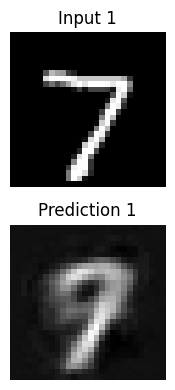

In [75]:
inputs, _ = next(iter(test_loader))
num_images = min(10, len(inputs))  # Adjust the number based on the actual batch size

fig, axes = plt.subplots(2, num_images, figsize=(2 * num_images, 4))  # 2 rows, num_images columns

# Check if axes is a 1D array and make it 2D if necessary
if num_images == 1:
    axes = axes.reshape(2, -1)  # Reshape to 2D (2 rows, 1 column)

for i in range(num_images):
    # Reshape and display the input images
    input_img = inputs[i].view(28, 28).numpy()  # Ensure inputs are reshaped to 28x28 for display
    axes[0, i].imshow(input_img, cmap='gray')
    axes[0, i].axis('off')  # Turn off axis numbering
    axes[0, i].set_title(f'Input {i+1}')

    # Reshape and display the predicted images
    pred_img = predictions[i].view(28, 28).numpy()
    axes[1, i].imshow(pred_img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Prediction {i+1}')

plt.tight_layout()
plt.show()